In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import sys
# Note: Make sure the python version in the path below matches your python version
sys.path.append("/content/drive/My Drive/dev/colab_env/lib/python3.10/site-packages")

!pip install virtualenv
!virtualenv '/content/drive/My Drive/dev/colab_env'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 38.4 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 32706ms
  creator CPython3Posix(dest=/content/drive/My Drive/dev/colab_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: Jinja2==3.1.2, MarkupSafe==2.1.3, Pillow==10.0.0, PyYAML==6.0, accelerate==0.20.3, certifi==2023.5.7, charset_normalizer==3.1.0, cmake==3.26.4, diffusers==0.15.0, filelock==3.12.2, fsspec==2023.6.0, fvcore==0.1.5.post20221221, huggingface_hub==0.16.2, idna==3.4, importlib_metadata==6.7.0, iopath==0.1.10, lit==16.0.6, mpmath==1.3.0, networkx==3.1, numpy==1.25.0, nvidia_cublas_cu11==11.10.3.66, nvidia_cuda_cupti_cu11==11.7.101, nvidia_cuda_nvrtc_cu11==11.7.99, nvidia_cu

## 1 - Imports

In [ ]:
import os
import sys
sys.path.append(os.path.abspath(''))

import torch
import cv2 as cv2
import numpy as np

In [ ]:
# pytorch3D Imports & Downloads
need_pytorch3d=False

try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

In [ ]:
!pip install transformers
!pip install opencv-contrib-python
!pip install controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.9/261.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.8 MB/s eta 0:00:00


In [ ]:
# controlNet dependencies
from diffusers.utils import load_image
from transformers import pipeline
from diffusers import (
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    UniPCMultistepScheduler
)


# utility libraries for visualization
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

from tqdm.notebook import tqdm

--2023-08-09 06:44:18--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-08-09 06:44:18 (33.5 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



## 2 - Render Mesh

---

- Load Mesh
- Initialize Renderer
- Render Views of Mesh: These will be the angles you use to generate new images and calculate your loss

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "dev/data"
obj_filename = os.path.join(DATA_DIR, "/content/drive/My Drive/dev/data/cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

In [ ]:
# get the original texture map
texture_map = mesh.textures.maps_padded()
ground_truth_map = texture_map.clone().detach()

In [ ]:
# initialize renderer
R, T = look_at_view_transform(dist=2.7, elev=0, azim=-90)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=[[2.0, 3.0, -3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

In [ ]:
def plot_tensor_im(tensor_im):

  plt.figure(figsize=(15, 7))
  plt.imshow(tensor_im.cpu().detach().numpy())
  plt.axis("off");

#### Render Views

In [ ]:
# SIDE VIEW
R, T = look_at_view_transform(dist=2.7, elev=0, azim=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
images = renderer(mesh)

side_view = images[0, ..., :3]

# FRONT VIEW
R, T = look_at_view_transform(2.7, 0, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
images = renderer(mesh, cameras=cameras)

front_view = images[0, ..., :3]

# BACK VIEW
R, T = look_at_view_transform(2.7, 30, 45)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
images = renderer(mesh, cameras=cameras)

back_view = images[0, ..., :3]

# TOP VIEW
R, T = look_at_view_transform(2.7, 90, 90)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
images = renderer(mesh, cameras=cameras)

top_view = images[0, ..., :3]

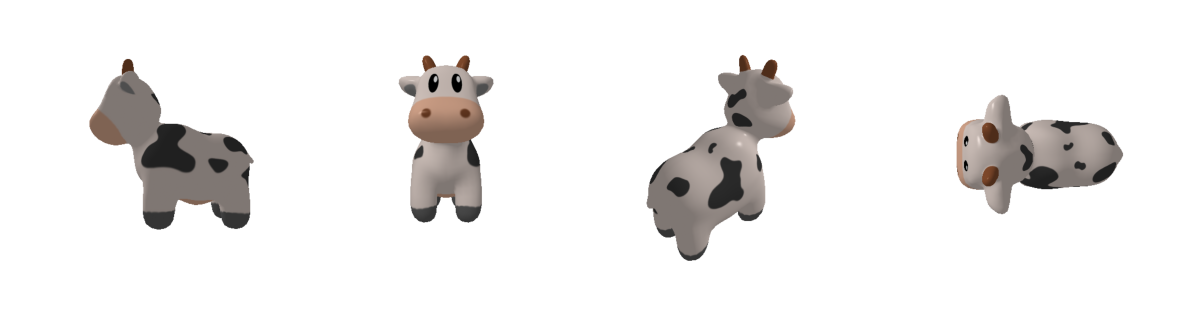

In [ ]:
og_cow_im  = torch.cat((side_view, front_view, back_view, top_view), 1)
plot_tensor_im(og_cow_im)

## 3 - Generate Target Images with MultiControl Net

---
We will use Stable Diffusion, MultiControl Net to Generate Target Images for our texture Map

- Conditioning Images: Manipulate our original renders to create inputs for control Net
- Write our prompts!


#### Image Conditioning
Canny Edge & Depth Map

In [ ]:
# GENERATE CANNY EDGE IMAGE
temp = np.array(og_cow_im.cpu())
temp = (temp*255).astype(np.uint8)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(temp, low_threshold, high_threshold)
image = image[:, :, None]  # Add dimension so image is height x width x channels
image = np.concatenate([image, image, image], axis=2)  # Duplicate 3rd dimension to make 3 channels to work with Image functions that expect RGB dimension
canny_image = Image.fromarray(image)  # Load from NumPy array to Image obje

(-0.5, 2559.5, 511.5, -0.5)

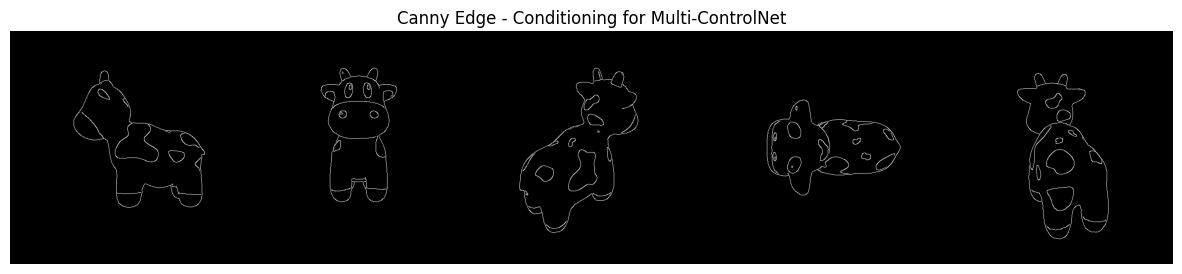

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Canny Edge - Conditioning for Multi-ControlNet")
plt.imshow(canny_image)
plt.axis("off")

In [ ]:
# GENERATE DEPTH MAP
import torchvision.transforms as T
transform = T.ToPILImage()

temp = transform(og_cow_im.cpu().permute(2, 0, 1))

depth_estimator = pipeline("depth-estimation")
image = depth_estimator(temp)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
depth_image = Image.fromarray(image)

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


(-0.5, 2559.5, 511.5, -0.5)

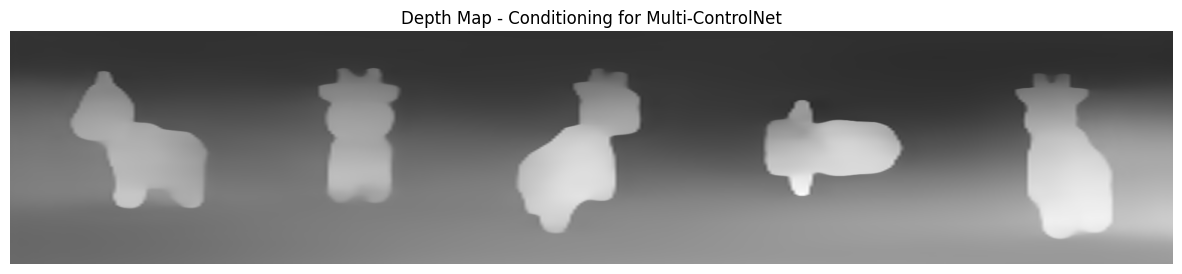

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Depth Map - Conditioning for Multi-ControlNet")
plt.imshow(depth_image)
plt.axis("off")

#### Initialize Multi-ControlNet

In [ ]:
controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
]

pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


#### Input your Text Prompt

In [ ]:
prompt = "character concept, marvel style, iron man inspired, iconic character, standing, in an empty white room, high resolution"
negative_prompt = "monochrome, lowres, extra anatomy, worst quality, low quality, extra cows, busy background"


#### Generate Images

In [ ]:
generator = torch.Generator(device="cpu").manual_seed(0)

images = [depth_image, canny_image]

output = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[1.0, 0.8],
).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Generated Images")
plt.imshow(output)
plt.axis("off")

#### Mask *Generated Images* to create **Target Images**
Note: We mask out the mesh in order to set the background to white. This way - when we re-render our mesh and compare it with our target images, the background doesn't factor into the loss calculation

In [ ]:
# CREATING THE MASK FROM THE ORIGINAL COW RENDERS

temp = np.array(og_cow_im.cpu())
temp = (temp*255).astype(np.uint8)

th, im_th = cv2.threshold( temp, 250, 255, cv2.THRESH_BINARY_INV);

im_floodfill = im_th.copy()
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

cv2.floodFill(im_floodfill, mask, (0,0), 255);
im_floodfill_inv = cv2.bitwise_not(im_floodfill)


im_out = im_th | im_floodfill_inv

In [ ]:
# APPLYING THE MASK TO THE GENERATED IMAGES
mask = im_out[:, :, 0]
mask = np.int8(mask/255)

gen_image = np.copy(output)

b=((~mask.astype(bool)).astype(int))*255

r = (gen_image[:, :, 0] * mask) + b
g = (gen_image[:, :, 1] * mask) + b
b = (gen_image[:, :, 2] * mask) + b

rgb = np.dstack((r,g,b))
target_im = rgb/255
target_im = torch.from_numpy(target_im)

if torch.cuda.is_available():
   target_imgs = target_im.cuda()

(-0.5, 2559.5, 511.5, -0.5)

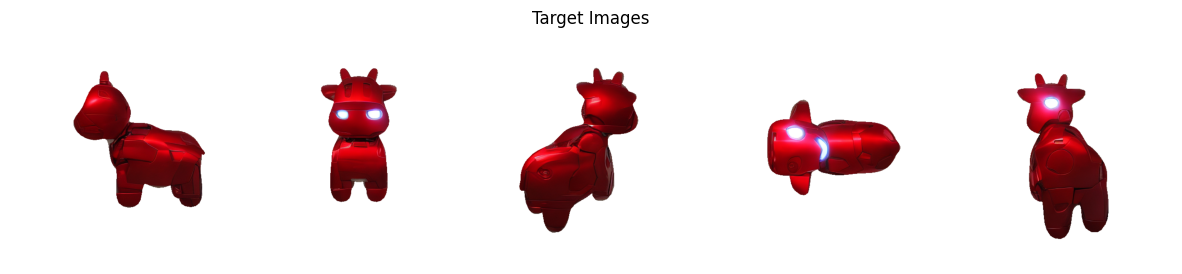

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Target Images")
plt.imshow(target_imgs.cpu())
plt.axis("off")

In [ ]:
# splitting the single long image into fourths
# preparing the target images for individual renders
side_target, front_target, back_target, top_target = torch.tensor_split(target_imgs, 4, dim=1)

## 4 - Optimization Loop

---
- Initialize Optimizer, Loss Parameters, Predicted Map

In [ ]:
# visualization util functions
def visualize_data():
  global front_target, side_target, back_target, top_target

  font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 10}

  plt.rc('font', **font)

  rows = 2
  col = 2
  fig = plt.figure(figsize=(7, 7))
  fig.suptitle("Target Images")

  fig.add_subplot(rows, col, 1)
  plt.imshow(front.cpu().detach().numpy())
  plt.axis('off')
  plt.title("FRONT", fontsize=8)

  fig.add_subplot(rows, col, 2)
  plt.imshow(side.cpu().detach().numpy())
  plt.axis('off')
  plt.title("SIDE", fontsize=8)

  fig.add_subplot(rows, col, 3)
  plt.imshow(back.cpu().detach().numpy())
  plt.axis('off')
  plt.title("BACK", fontsize=8)

  fig.add_subplot(rows, col, 4)
  plt.imshow(top.cpu().detach().numpy())
  plt.axis('off')
  plt.title("TOP", fontsize=8)

def plot_losses(losses):

    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()

    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")

    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

def visualize_results(pred_map, iteration):
  font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 10}

  global target_map

  rows = 1
  col = 1
  fig = plt.figure(figsize=(7, 3))
  fig.suptitle("Predicted Map - Iteration: %d" % iteration)

  fig.add_subplot(rows, col, 1)
  plt.imshow(pred_map[0].cpu().detach().numpy())
  plt.axis('off')


def visualize_2d_results(target_im, pred_im, pred_map, iteration):
  font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 10}

  plt.rc('font', **font)

  rows = 1
  col = 3
  fig = plt.figure(figsize=(10, 4))
  fig.suptitle("Iteration: %d" % iteration)

  fig.add_subplot(rows, col, 1)
  plt.imshow(target_im.cpu().detach().numpy())
  plt.axis('off')
  plt.title("Target Image", fontsize=8)

  fig.add_subplot(rows, col, 2)
  plt.imshow(pred_im.cpu().detach().numpy())
  plt.axis('off')
  plt.title("Rendered Image", fontsize=8)

  fig.add_subplot(rows, col, 3)
  plt.imshow(pred_map[0].cpu().detach().numpy())
  plt.axis('off')
  plt.title("Predicted Map", fontsize=8)


#### 2D Optimization
Predicting a texture map based on a single view.

###### Initialize Optimizer Settings

In [ ]:
# Number of optimization steps
Niter = 150

# Plot period for the losses
plot_period = 25

# get the original texture map
target_map = ground_truth_map
predicted_map = torch.rand(target_map.shape, device = device, requires_grad = True)

# Select View you want to Optimize for
target_im = side_target

%matplotlib inline

# Optimize using rendered RGB image loss
losses = { "rgb": {"weight": 1.0, "values": []} }

# The optimizer
optimizer = torch.optim.Adam([predicted_map], lr=5.0)

Text(0.5, 1.0, 'Predicted Map')

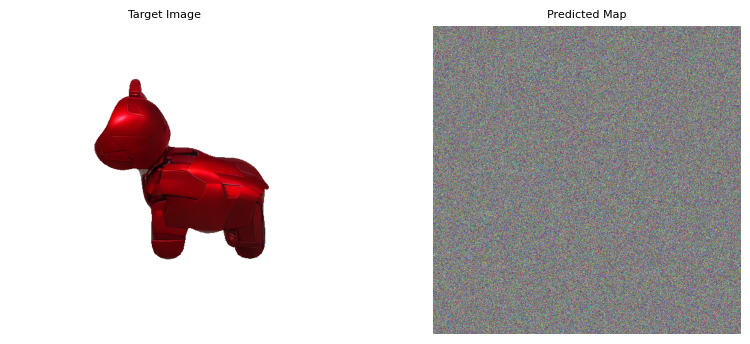

In [ ]:
rows = 1
col = 2
fig = plt.figure(figsize=(10, 4))

fig.add_subplot(rows, col, 1)
# showing image
plt.imshow(target_im.cpu().detach().numpy())
plt.axis('off')
plt.title("Target Image", fontsize=8)

fig.add_subplot(rows, col, 2)
# showing image
plt.imshow(predicted_map[0].cpu().detach().numpy())
plt.axis('off')
plt.title("Predicted Map", fontsize=8)

##### Optimizer Loop

  0%|          | 0/150 [00:00<?, ?it/s]

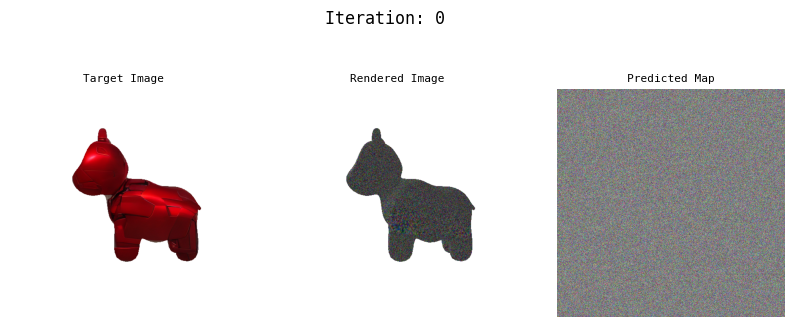

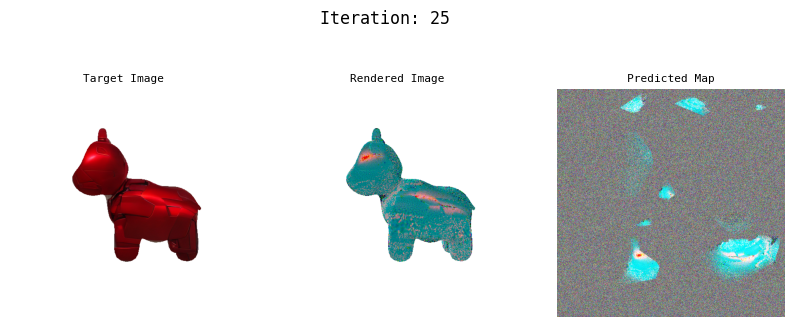

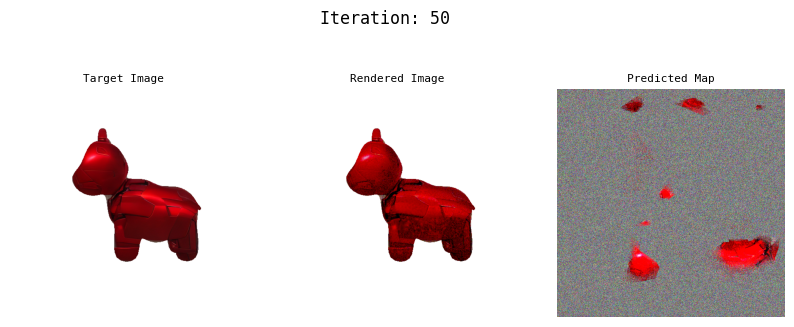

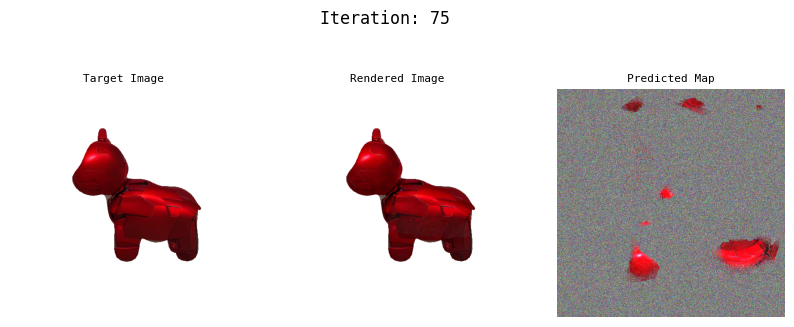

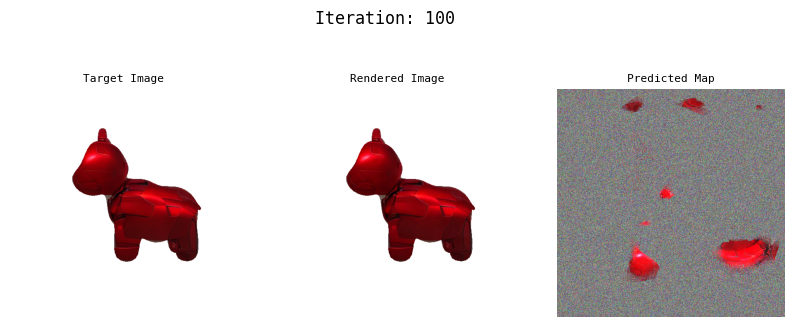

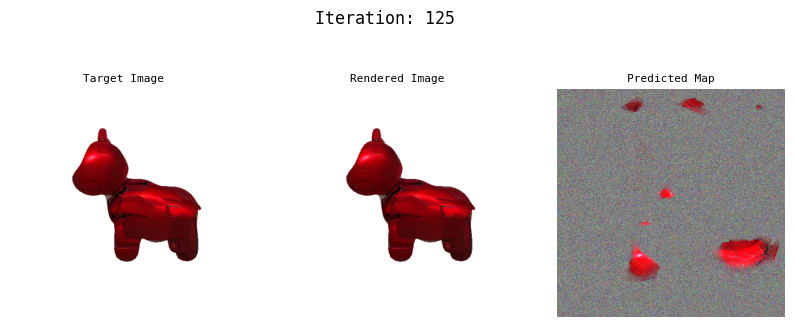

In [ ]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Apply updated texture to mesh
    new_texture = TexturesUV(maps=predicted_map,
                         faces_uvs=mesh.textures.faces_uvs_padded(),
                         verts_uvs=mesh.textures.verts_uvs_padded())

    mesh.textures = new_texture

    # Render new Image
    R, T = look_at_view_transform(2.7, 0, -90)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    images = renderer(mesh, lights=lights, cameras=cameras)
    predicted_im = images[0, ..., :3]

    # Calculate Loss
    loss_rgb = ((predicted_im - target_im) ** 2).mean()

    # Print the losses
    loop.set_description("Total Loss = %.6f" % loss_rgb)

    # Plot mesh
    if i % plot_period == 0:
        visualize_2d_results(target_im, predicted_im, predicted_map, i)

    # Optimization step
    loss_rgb.backward()
    optimizer.step()

###### Results
Looks good? The image rendered from our predicted map looks really close. Pretty much identical to the target image.


In [ ]:
# RENDER OUR MESH FROM ANOTHER ANGLE
R, T = look_at_view_transform(2.7, 0, -120)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
images = renderer(mesh, cameras=cameras)

test = images[0, ..., :3]

Text(0.5, 1.0, 'Predicted Map')

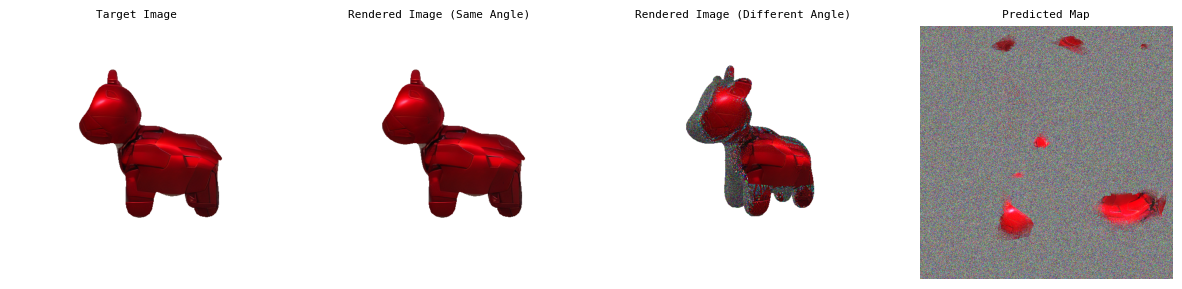

In [ ]:
rows = 1
col = 4
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(rows, col, 1)
# showing image
plt.imshow(target_im.cpu().detach().numpy())
plt.axis('off')
plt.title("Target Image", fontsize=8)

fig.add_subplot(rows, col, 2)
# showing image
plt.imshow(predicted_im.cpu().detach().numpy())
plt.axis('off')
plt.title("Rendered Image (Same Angle)", fontsize=8)

fig.add_subplot(rows, col, 3)
# showing image
plt.imshow(test.cpu().detach().numpy())
plt.axis('off')
plt.title("Rendered Image (Different Angle)", fontsize=8)

fig.add_subplot(rows, col, 4)
# showing image
plt.imshow(predicted_map[0].cpu().detach().numpy())
plt.axis('off')
plt.title("Predicted Map", fontsize=8)


When we render our mesh from a slightly different angle, we can see the problem with our predicted *texture map*.

#### 3D Optimization
To fix the problem, we are going to try to predict a texture map based on multiple views.

In [ ]:
# Number of optimization steps
Niter = 400

# Plot period for the losses
plot_period = 100

# get the original texture map
target_map = ground_truth_map
predicted_map = torch.rand(target_map.shape, device = device, requires_grad = True)

%matplotlib inline

# Optimize using rendered RGB image loss
losses = {  "front": {"weight": 1.0, "values": []},
            "side": {"weight": 1.0, "values": []},
            "back": {"weight": 1000.0, "values": []},
            "top": {"weight": 1.0, "values": []}}

# The optimizer
optimizer = torch.optim.Adam([predicted_map], lr=20.0)

Text(0.5, 1.0, 'Predicted Map')

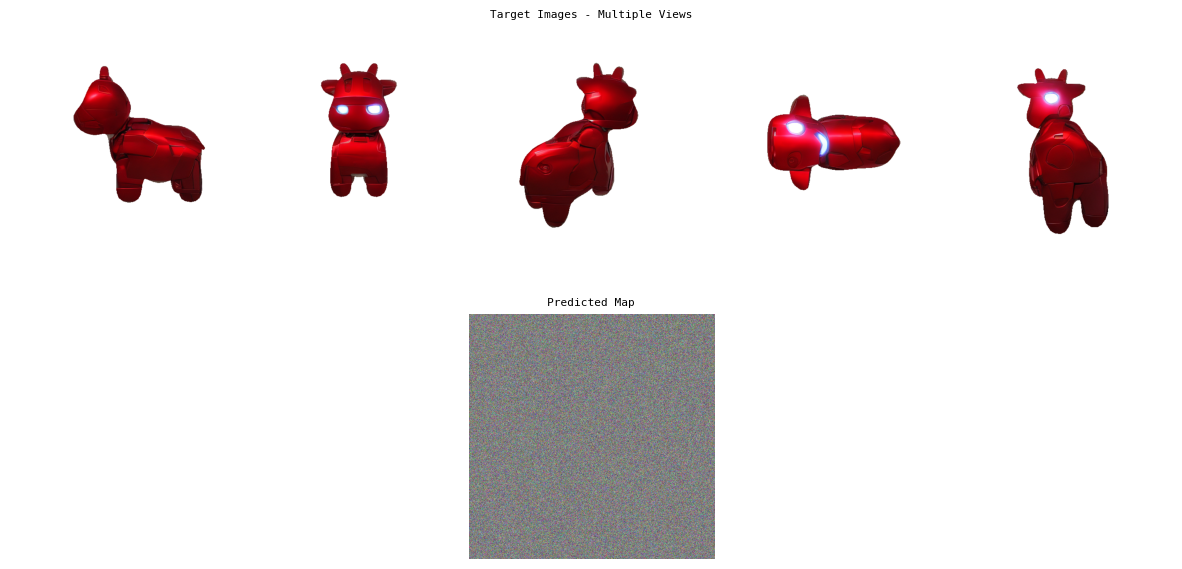

In [ ]:
rows = 2
col = 1
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(rows, col, 1)
# showing image
plt.imshow(target_imgs.cpu())
plt.axis('off')
plt.title("Target Images - Multiple Views", fontsize=8)

fig.add_subplot(rows, col, 2)
# showing image
plt.imshow(predicted_map[0].cpu().detach().numpy())
plt.axis('off')
plt.title("Predicted Map", fontsize=8)

  0%|          | 0/400 [00:00<?, ?it/s]

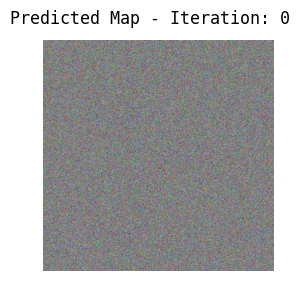

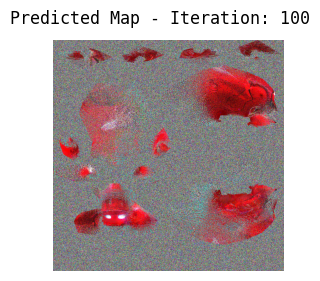

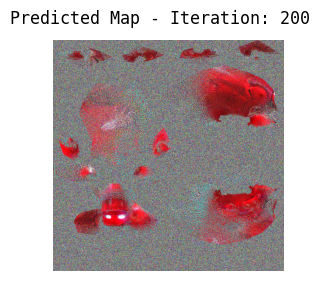

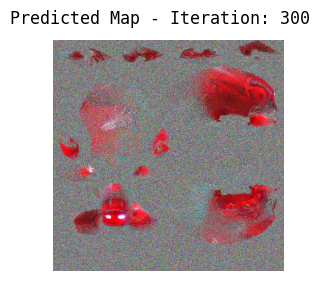

In [ ]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Apply updated texture to mesh
    new_texture = TexturesUV(maps=predicted_map,
                          faces_uvs=mesh.textures.faces_uvs_padded(),
                          verts_uvs=mesh.textures.verts_uvs_padded())

    mesh.textures = new_texture

    # Render new Images

    # FRONT RENDER
    R, T = look_at_view_transform(2.7, 0, 180)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    images = renderer(mesh, cameras=cameras)

    predicted_FRONT = images[0, ..., :3]

    # SIDE RENDER
    R, T = look_at_view_transform(2.7, 0, -90)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    images = renderer(mesh, cameras=cameras)

    predicted_SIDE = images[0, ..., :3]

    # BACK RENDER
    R, T = look_at_view_transform(2.7, 30, 45)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    images = renderer(mesh, cameras=cameras)

    predicted_BACK = images[0, ..., :3]

    # TOP RENDER
    R, T = look_at_view_transform(2.7, 90, 90)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    images = renderer(mesh, cameras=cameras)

    predicted_TOP = images[0, ..., :3]


    loss = {k: torch.tensor(0.0, device=device) for k in losses}

    # Calculate Loss
    loss_front = ((predicted_FRONT - front_target) ** 2).mean()
    loss["front"] += loss_front

    loss_side = ((predicted_SIDE - side_target) ** 2).mean()
    loss["side"] += loss_side

    loss_back = ((predicted_BACK - back_target) ** 2).mean()
    loss["back"] += loss_back

    loss_top = ((predicted_TOP - top_target) ** 2).mean()
    loss["top"] += loss_top


    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    sum_loss = sum_loss/4.0

    # Print the losses
    loop.set_description("Total Loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        visualize_results(predicted_map, i)

    # Optimization step
    sum_loss.backward()
    optimizer.step()

In [ ]:
# Testing same Angle Render
R, T = look_at_view_transform(2.7, 0, -90)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
images = renderer(mesh, cameras=cameras)

test_1 = images[0, ..., :3]

# Testing Different angle Render
R, T = look_at_view_transform(2.7, 0, -120)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
images = renderer(mesh, cameras=cameras)

test_2 = images[0, ..., :3]

Text(0.5, 1.0, 'Predicted Map')

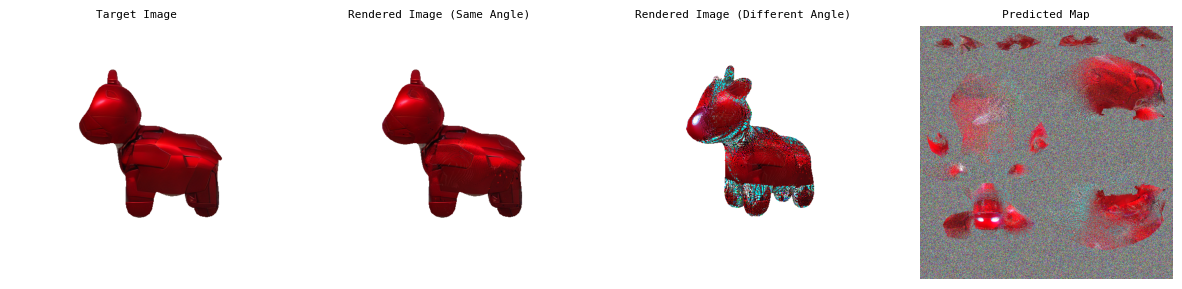

In [ ]:
rows = 1
col = 4
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(rows, col, 1)
# showing image
plt.imshow(side_target.cpu().detach().numpy())
plt.axis('off')
plt.title("Target Image", fontsize=8)

fig.add_subplot(rows, col, 2)
# showing image
plt.imshow(test_1.cpu().detach().numpy())
plt.axis('off')
plt.title("Rendered Image (Same Angle)", fontsize=8)

fig.add_subplot(rows, col, 3)
# showing image
plt.imshow(test_2.cpu().detach().numpy())
plt.axis('off')
plt.title("Rendered Image (Different Angle)", fontsize=8)

fig.add_subplot(rows, col, 4)
# showing image
plt.imshow(predicted_map[0].cpu().detach().numpy())
plt.axis('off')
plt.title("Predicted Map", fontsize=8)


In [ ]:
batch_size = 20
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles.
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)


lights = PointLights(device=device, location=[[3.0, 3.0, -3.0]])

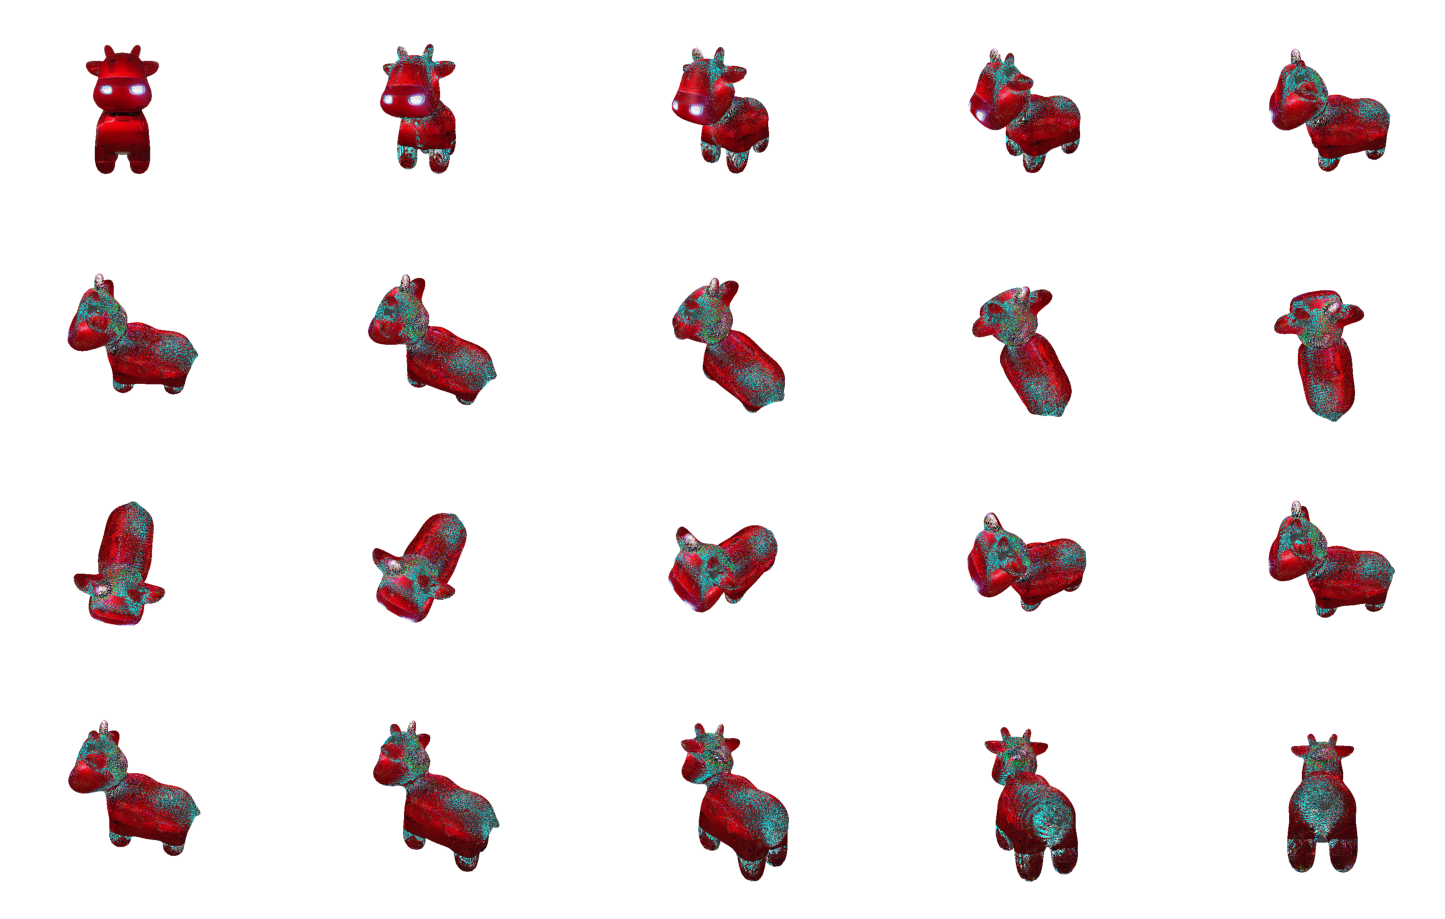

In [ ]:
images = renderer(meshes, cameras=cameras, lights=lights)
image_grid(images.cpu().detach().numpy(), rows=4, cols=5, rgb=True)

In [ ]:
from torchvision.transforms import ToPILImage

In [ ]:
if not os.path.exists('/content/drive/My Drive/dev/data/iron_img'):
    os.makedirs('/content/drive/My Drive/dev/data/iron_img')

# render the model from many viewpoints to create a spinning gif later

for azimuth in np.linspace(0, 360, 61):
    R, T = look_at_view_transform(dist=2.7, elev=0, azim=azimuth)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    images = renderer(mesh, cameras=cameras)

    # convert the rendered tensor to a PIL image
    image = images[0, ..., :3].clamp(0.0, 1.0).detach().cpu().permute(2, 0, 1)
    image = ToPILImage()(image)
    image.save(f'/content/drive/My Drive/dev/data/iron_img/cow_{azimuth}.png')

(-0.5, 1023.5, 1023.5, -0.5)

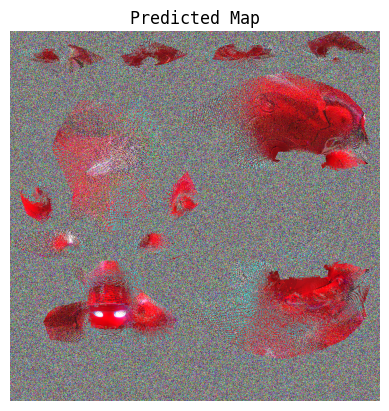

In [ ]:
  # showing image
  plt.title("Predicted Map")
  plt.imshow(predicted_map[0].cpu().detach().numpy())
  plt.axis('off')